In [1]:
import os
import sys
import urllib, io
os.getcwd()
sys.path.append("..")
sys.path.append("../utils")
sys.path.append("../analysis/utils")
import glob

import numpy as np
import scipy.stats as stats
import pandas as pd

import pymongo as pm
from collections import Counter
import json
import re
import ast

from PIL import Image, ImageOps, ImageDraw, ImageFont 

from io import BytesIO
import base64

import  matplotlib
from matplotlib import pylab, mlab, pyplot
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

import seaborn as sns
sns.set_context('talk')
sns.set_style('darkgrid')

from IPython.display import clear_output

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

In [2]:
## directory & file hierarchy
proj_dir = os.path.abspath('..')
datavol_dir = os.path.join(proj_dir,'data')
analysis_dir =  os.path.abspath('.')
results_dir = os.path.join(proj_dir,'results')
plot_dir = os.path.join(results_dir,'plots')
csv_dir = os.path.join(results_dir,'csv')
json_dir = os.path.join(results_dir,'json')
exp_dir = os.path.abspath(os.path.join(proj_dir,'behavioral_experiments'))
png_dir = os.path.abspath(os.path.join(datavol_dir,'png'))

## add helpers to python path
if os.path.join(proj_dir,'stimuli') not in sys.path:
    sys.path.append(os.path.join(proj_dir,'stimuli'))
    
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
    
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)   
    
if not os.path.exists(csv_dir):
    os.makedirs(csv_dir)       

### Import model results

In [3]:
model_output_dir = os.path.abspath('../language_output/')

all_files = glob.glob(model_output_dir + "/*.csv")

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

df_model = pd.concat(li, axis=0, ignore_index=True).sort_values(['ppt','iteration','chainNum','alpha','beta','trialNum'])

# # swap mislabeled columns
# intendedSequence = df_model['speakerUtterance'].copy()
# speakerUtterance = df_model['intendedSequence'].copy()
# df_model['speakerUtterance'] = speakerUtterance
# df_model['intendedSequence'] = intendedSequence

- iterationName: 0 to 99
- chainNum: index for parameter pair
- alpha: 
- beta: 

In [4]:
df_model

,chainNum,ppt,iteration,alpha,beta,trialNum,accuracy,descriptionLength,intendedSequence,speakerUtterance,listenerResponse
35352,0,1,0,1,0.0,0,True,14,h l_4 h l_1 v v r_9 v r_6 v l_5 h r_4 h,place a horizontal block.~~~move to the left b...,h l_4 h l_1 v v r_9 v r_6 v l_5 h r_4 h
35353,0,1,0,1,0.0,1,True,13,h l_4 h l_1 v v r_12 h l_1 v v r_1 h,place a horizontal block.~~~move to the left b...,h l_4 h l_1 v v r_12 h l_1 v v r_1 h
35354,0,1,0,1,0.0,2,True,14,h l_1 v v r_1 h r_6 v r_6 v l_5 h r_4 h,place a horizontal block.~~~move to the left b...,h l_1 v v r_1 h r_6 v r_6 v l_5 h r_4 h
35355,0,1,0,1,0.0,3,True,11,v r_6 v l_5 h r_4 h r_7 chunk_8b r_1 h,place a vertical block.~~~move to the right by...,v r_6 v l_5 h r_4 h r_7 chunk_8b r_1 h
35356,0,1,0,1,0.0,4,False,13,h l_1 v v r_1 h r_12 h l_4 h l_1 v v,place a horizontal block.~~~move to the left b...,h l_1 v v r_1 h r_12 r_5 l_4 h l_1 v v
...,...,...,...,...,...,...,...,...,...,...,...
11491,2155,49,1,64,1.0,7,False,3,chunk_L r_12 chunk_C,bloop~~~move to the right by 12~~~bloop,chunk_Pi r_12 chunk_8b
11492,2155,49,1,64,1.0,8,False,3,chunk_C r_6 chunk_Pi,bloop~~~move to the right by 6~~~bleep,chunk_8b r_0 chunk_C
11493,2155,49,1,64,1.0,9,False,3,chunk_C r_12 chunk_L,bloop~~~move to the right by 12~~~bloop,chunk_8b r_12 chunk_8b
11494,2155,49,1,64,1.0,10,False,3,chunk_Pi r_7 chunk_C,blah~~~move to the right by 7~~~bleep,chunk_C r_7 chunk_8


In [5]:
def get_intended_refs(intendedSequenceList):
    return[exp for exp in intendedSequenceList if ((not exp.startswith('r_')) & ( not exp.startswith('l_')))]

In [6]:
# preprocessing

df_model['intendedSequenceList'] = df_model['intendedSequence'].apply(lambda string: string.split(' '))
df_model['listenerResponseList'] = df_model['listenerResponse'].apply(lambda string: string.split(' '))
df_model['speakerUtteranceList'] = df_model['speakerUtterance'].apply(lambda string: string.split('~~~'))

df_model['speakerUtteranceWords'] = df_model['speakerUtterance'].apply(lambda string: string.split('~~~'))
df_model['intended_refs'] = df_model['intendedSequenceList'].apply(get_intended_refs)

#checks
assert np.all(df_model['intendedSequenceList'].apply(len) == df_model['descriptionLength'])
assert np.all(df_model['speakerUtteranceList'].apply(len) == df_model['descriptionLength'])

In [7]:
df_model['repetition'] = np.floor((df_model['trialNum']/3))+1

In [8]:
intended_abstraction_levels = {
    'v': 'block',
    'h': 'block',
    'chunk_L': 'tower',
    'chunk_Pi': 'tower',
    'chunk_C': 'tower',
    'chunk_8': 'subtower',
    'chunk_8b': 'subtower',
    'chunk_9': 'subtower'
}

In [9]:
def abstraction_level(intended_ref):
    assert intended_ref in intended_abstraction_levels.keys()
    if intended_ref in intended_abstraction_levels.keys():
        return intended_abstraction_levels[intended_ref]
    else:
        print(intended_ref)
        return 'UNKNOWN'

In [10]:
df_model['intended_abstraction_level'] = \
        df_model['intended_refs'].apply(lambda intended_refs: [abstraction_level(ref) for ref in intended_refs])

In [11]:
df_model['intended_blocks'] = df_model['intended_abstraction_level'].apply(lambda x: Counter(x)['block'])
df_model['intended_subtowers'] = df_model['intended_abstraction_level'].apply(lambda x: Counter(x)['subtower'])
df_model['intended_towers'] = df_model['intended_abstraction_level'].apply(lambda x: Counter(x)['tower'])

In [12]:
df_model

,chainNum,ppt,iteration,alpha,beta,trialNum,accuracy,descriptionLength,intendedSequence,speakerUtterance,...,intendedSequenceList,listenerResponseList,speakerUtteranceList,speakerUtteranceWords,intended_refs,repetition,intended_abstraction_level,intended_blocks,intended_subtowers,intended_towers
27696,0,1,0,1,0.0,0,True,14,h l_4 h l_1 v v r_9 v r_6 v l_5 h r_4 h,place a horizontal block.~~~move to the left b...,...,"[h, l_4, h, l_1, v, v, r_9, v, r_6, v, l_5, h,...","[h, l_4, h, l_1, v, v, r_9, v, r_6, v, l_5, h,...","[place a horizontal block., move to the left b...","[place a horizontal block., move to the left b...","[h, h, v, v, v, v, h, h]",1.0,"[block, block, block, block, block, block, blo...",8,0,0
27697,0,1,0,1,0.0,1,True,13,h l_4 h l_1 v v r_12 h l_1 v v r_1 h,place a horizontal block.~~~move to the left b...,...,"[h, l_4, h, l_1, v, v, r_12, h, l_1, v, v, r_1...","[h, l_4, h, l_1, v, v, r_12, h, l_1, v, v, r_1...","[place a horizontal block., move to the left b...","[place a horizontal block., move to the left b...","[h, h, v, v, h, v, v, h]",1.0,"[block, block, block, block, block, block, blo...",8,0,0
27698,0,1,0,1,0.0,2,True,14,h l_1 v v r_1 h r_6 v r_6 v l_5 h r_4 h,place a horizontal block.~~~move to the left b...,...,"[h, l_1, v, v, r_1, h, r_6, v, r_6, v, l_5, h,...","[h, l_1, v, v, r_1, h, r_6, v, r_6, v, l_5, h,...","[place a horizontal block., move to the left b...","[place a horizontal block., move to the left b...","[h, v, v, h, v, v, h, h]",1.0,"[block, block, block, block, block, block, blo...",8,0,0
27699,0,1,0,1,0.0,3,True,11,v r_6 v l_5 h r_4 h r_7 chunk_8b r_1 h,place a vertical block.~~~move to the right by...,...,"[v, r_6, v, l_5, h, r_4, h, r_7, chunk_8b, r_1...","[v, r_6, v, l_5, h, r_4, h, r_7, chunk_8b, r_1...","[place a vertical block., move to the right by...","[place a vertical block., move to the right by...","[v, v, h, h, chunk_8b, h]",2.0,"[block, block, block, block, subtower, block]",5,1,0
27700,0,1,0,1,0.0,4,False,13,h l_1 v v r_1 h r_12 h l_4 h l_1 v v,place a horizontal block.~~~move to the left b...,...,"[h, l_1, v, v, r_1, h, r_12, h, l_4, h, l_1, v...","[h, l_1, v, v, r_1, h, r_12, r_5, l_4, h, l_1,...","[place a horizontal block., move to the left b...","[place a horizontal block., move to the left b...","[h, v, v, h, h, h, v, v]",2.0,"[block, block, block, block, block, block, blo...",8,0,0
27701,0,1,0,1,0.0,5,True,14,v r_6 v l_5 h r_4 h r_9 h l_4 h l_1 v v,place a vertical block.~~~move to the right by...,...,"[v, r_6, v, l_5, h, r_4, h, r_9, h, l_4, h, l_...","[v, r_6, v, l_5, h, r_4, h, r_9, h, l_4, h, l_...","[place a vertical block., move to the right by...","[place a vertical block., move to the right by...","[v, v, h, h, h, h, v, v]",2.0,"[block, block, block, block, block, block, blo...",8,0,0
27702,0,1,0,1,0.0,6,True,13,h l_4 h l_1 v v r_12 h l_1 v v r_1 h,place a horizontal block.~~~move to the left b...,...,"[h, l_4, h, l_1, v, v, r_12, h, l_1, v, v, r_1...","[h, l_4, h, l_1, v, v, r_12, h, l_1, v, v, r_1...","[place a horizontal block., move to the left b...","[place a horizontal block., move to the left b...","[h, h, v, v, h, v, v, h]",3.0,"[block, block, block, block, block, block, blo...",8,0,0
27703,0,1,0,1,0.0,7,True,14,h l_1 v v r_1 h r_6 v r_6 v l_5 h r_4 h,place a horizontal block.~~~move to the left b...,...,"[h, l_1, v, v, r_1, h, r_6, v, r_6, v, l_5, h,...","[h, l_1, v, v, r_1, h, r_6, v, r_6, v, l_5, h,...","[place a horizontal block., move to the left b...","[place a horizontal block., move to the left b...","[h, v, v, h, v, v, h, h]",3.0,"[block, block, block, block, block, block, blo...",8,0,0
27704,0,1,0,1,0.0,8,True,14,h l_4 h l_1 v v r_9 v r_6 v l_5 h r_4 h,place a horizontal block.~~~move to the left b...,...,"[h, l_4, h, l_1, v, v, r_9, v, r_6, v, l_5, h,...","[h, l_4, h, l_1, v, v, r_9, v, r_6, v, l_5, h,...","[place a horizontal block., move to the left b...","[place a horizontal block., move to the left b...","[h, h, v, v, v, v, h, h]",3.0,"[

In [13]:
def score_action_response(intended, executed):
    if intended==executed:
        if (intended.startswith('l_') or intended.startswith('r_')):
            return 0
        if (intended=='h') or (intended=='v'):
            return 1
        if (intended=='chunk_Pi') or (intended=='chunk_L') or (intended=='chunk_C'):
            return 4
        if (intended=='chunk_8') or (intended=='chunk_8b'):
            return 3
        if (intended=='chunk_9'):
            return 2
        else:
            print(intended)
    else:
        return 0

In [14]:
# plus one for every correct block in referring expressions 
df_model['soft_score'] = [sum(list(score_action_response(a,b) for (a,b) in zip(row['intendedSequenceList'], 
                                                                               row['listenerResponseList'])))\
                                                                  for i, row in df_model.iterrows()] 


In [15]:
# soft accuracy
df_model['correct_action'] = [list(a == b for (a,b) in zip(row['intendedSequenceList'], row['listenerResponseList'])) for i, row in df_model.iterrows()] 


In [16]:
df_model['prop_correct_action'] = df_model['correct_action'].apply(np.mean)

## Referring expressions

In [17]:
df_model[df_model.beta.isin([0,0.2,0.4,0.6,0.8,1])]

,chainNum,ppt,iteration,alpha,beta,trialNum,accuracy,descriptionLength,intendedSequence,speakerUtterance,...,speakerUtteranceWords,intended_refs,repetition,intended_abstraction_level,intended_blocks,intended_subtowers,intended_towers,soft_score,correct_action,prop_correct_action
27696,0,1,0,1,0.0,0,True,14,h l_4 h l_1 v v r_9 v r_6 v l_5 h r_4 h,place a horizontal block.~~~move to the left b...,...,"[place a horizontal block., move to the left b...","[h, h, v, v, v, v, h, h]",1.0,"[block, block, block, block, block, block, blo...",8,0,0,8,"[True, True, True, True, True, True, True, Tru...",1.000000
27697,0,1,0,1,0.0,1,True,13,h l_4 h l_1 v v r_12 h l_1 v v r_1 h,place a horizontal block.~~~move to the left b...,...,"[place a horizontal block., move to the left b...","[h, h, v, v, h, v, v, h]",1.0,"[block, block, block, block, block, block, blo...",8,0,0,8,"[True, True, True, True, True, True, True, Tru...",1.000000
27698,0,1,0,1,0.0,2,True,14,h l_1 v v r_1 h r_6 v r_6 v l_5 h r_4 h,place a horizontal block.~~~move to the left b...,...,"[place a horizontal block., move to the left b...","[h, v, v, h, v, v, h, h]",1.0,"[block, block, block, block, block, block, blo...",8,0,0,8,"[True, True, True, True, True, True, True, Tru...",1.000000
27699,0,1,0,1,0.0,3,True,11,v r_6 v l_5 h r_4 h r_7 chunk_8b r_1 h,place a vertical block.~~~move to the right by...,...,"[place a vertical block., move to the right by...","[v, v, h, h, chunk_8b, h]",2.0,"[block, block, block, block, subtower, block]",5,1,0,8,"[True, True, True, True, True, True, True, Tru...",1.000000
27700,0,1,0,1,0.0,4,False,13,h l_1 v v r_1 h r_12 h l_4 h l_1 v v,place a horizontal block.~~~move to the left b...,...,"[place a horizontal block., move to the left b...","[h, v, v, h, h, h, v, v]",2.0,"[block, block, block, block, block, block, blo...",8,0,0,7,"[True, True, True, True, True, True, True, Fal...",0.923077
27701,0,1,0,1,0.0,5,True,14,v r_6 v l_5 h r_4 h r_9 h l_4 h l_1 v v,place a vertical block.~~~move to the right by...,...,"[place a vertical block., move to the right by...","[v, v, h, h, h, h, v, v]",2.0,"[block, block, block, block, block, block, blo...",8,0,0,8,"[True, True, True, True, True, True, True, Tru...",1.000000
27702,0,1,0,1,0.0,6,True,13,h l_4 h l_1 v v r_12 h l_1 v v r_1 h,place a horizontal block.~~~move to the left b...,...,"[place a horizontal block., move to the left b...","[h, h, v, v, h, v, v, h]",3.0,"[block, block, block, block, block, block, blo...",8,0,0,8,"[True, True, True, True, True, True, True, Tru...",1.000000
27703,0,1,0,1,0.0,7,True,14,h l_1 v v r_1 h r_6 v r_6 v l_5 h r_4 h,place a horizontal block.~~~move to the left b...,...,"[place a horizontal block., move to the left b...","[h, v, v, h, v, v, h, h]",3.0,"[block, block, block, block, block, block, blo...",8,0,0,8,"[True, True, True, True, True, True, True, Tru...",1.000000
27704,0,1,0,1,0.0,8,True,14,h l_4 h l_1 v v r_9 v r_6 v l_5 h r_4 h,place a horizontal block.~~~move to the left b...,...,"[place a horizontal block., move to the left b...","[h, h, v, v, v, v, h, h]",3.0,"[block, block, block, block, block, block, blo...",8,0,0,8,"[True, True, True, True, True, True, True, Tru...",1.000000
27705,0,1,0,1,0.0,9,True,13,h l_1 v v r_1 h r_12 h l_4 h l_1 v v,place a horizontal block.~~~move to the left b...,...,"[place a horizontal block., move to the left b...","[h, v, v, h, h, h, v, v]",4.0,"[block, block, block, block, block, block, blo...",8,0,0,8,"[True, True, True, True, True, True, True, Tru...",1.000000


In [18]:
black = sns.light_palette("#000000", reverse=False, as_cmap=True)
red = sns.light_palette("#FF0000", reverse=False, as_cmap=True)
green = sns.light_palette("#008000", reverse=False, as_cmap=True)

[Text(0.5, 0, '')]

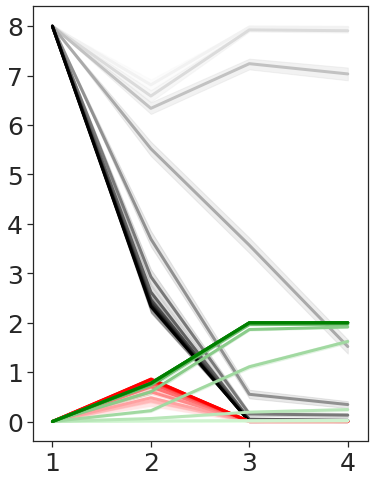

In [19]:
fig = plt.figure(figsize=(6,8))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend':False})
sns.set(style="ticks", rc={"lines.linewidth": 3})
sns.lineplot(data=df_model, x='repetition', y='intended_blocks', hue='beta', palette=black)
sns.lineplot(data=df_model, x='repetition', y='intended_subtowers', hue='beta', palette=red)
g = sns.lineplot(data=df_model, x='repetition', y='intended_towers', hue='beta', palette=green)
g.legend().remove()
g.set(xlim=(0.8,4.2))
g.set(xticks=[1,2,3,4])
g.set(xticklabels=['1','2','3','4'])
g.set_yticklabels([str(int(y)) for y in g.get_yticks()], size = 25)
g.set_xticklabels([str(int(x)) for x in g.get_xticks()], size = 25)
g.set(ylabel='')
g.set(xlabel='')

In [20]:
df_model_avg = df_model.groupby(['ppt','alpha','beta','repetition']).mean().reset_index()

[Text(0.5, 0, '')]

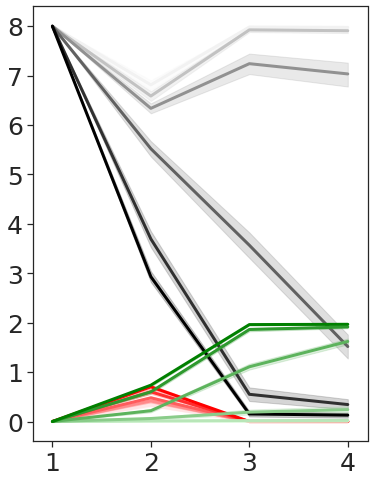

In [21]:
# revised plot

subset = df_model_avg[df_model_avg.beta <= 0.5]

fig = plt.figure(figsize=(6,8))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend':False})
sns.set(style="ticks", rc={"lines.linewidth": 3})
sns.lineplot(data=subset, x='repetition', y='intended_blocks', hue='beta', palette=black)
sns.lineplot(data=subset, x='repetition', y='intended_subtowers', hue='beta', palette=red)
g = sns.lineplot(data=subset, x='repetition', y='intended_towers', hue='beta', palette=green)
g.legend().remove()
g.set(xlim=(0.8,4.2))
g.set(xticks=[1,2,3,4])
g.set(xticklabels=['1','2','3','4'])
g.set_yticklabels([str(int(y)) for y in g.get_yticks()], size = 25)
g.set_xticklabels([str(int(x)) for x in g.get_xticks()], size = 25)
g.set(ylabel='')
g.set(xlabel='')

In [22]:
#fig.savefig('../../figures/cogsci2021_model_expressions_all_seqs.pdf', transparent=False, bbox_inches='tight', pad_inches=0)

<Figure size 1440x576 with 0 Axes>

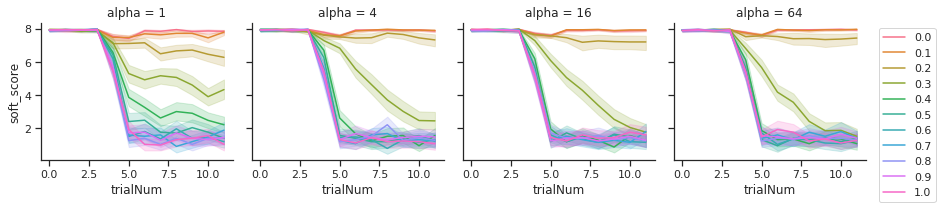

In [23]:
fig = plt.figure(figsize=(20,8))
sns.set_context('poster')
sns.set_style('whitegrid')
sns.set(style="ticks", rc={"lines.linewidth": 1.5})
g = sns.FacetGrid(df_model, col='alpha', col_wrap=8, hue='beta')
g.map(sns.lineplot, 'trialNum', 'soft_score')
plt.legend(bbox_to_anchor=(1.04, 1))

<Figure size 864x576 with 0 Axes>

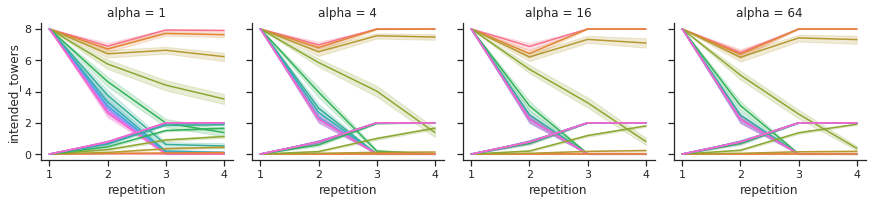

In [24]:
fig = plt.figure(figsize=(12,8))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend':False})
sns.set(style="ticks", rc={"lines.linewidth": 1.5})
g = sns.FacetGrid(df_model, col='alpha', col_wrap=8, hue='beta')
g.map(sns.lineplot, 'repetition', 'intended_blocks')
# g.map(sns.lineplot, 'trialNum', 'intended_subtowers')
g.map(sns.lineplot, 'repetition', 'intended_towers')

In [25]:
#fig.savefig('../../figures/cogsci2021_model_expressions.pdf', transparent=False, bbox_inches='tight', pad_inches=0)

## Accuracy

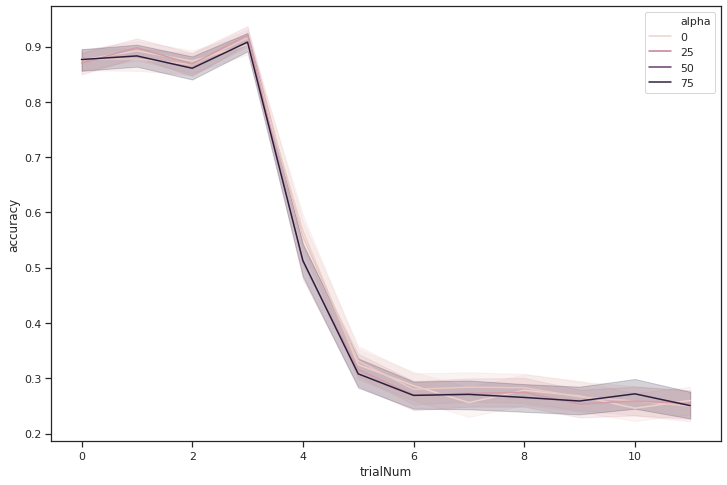

In [26]:
fig = plt.figure(figsize=(12,8))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend':False})
sns.set(style="ticks", rc={"lines.linewidth": 1.5})
sns.lineplot(data=df_model, y='accuracy', x='trialNum', hue='alpha')

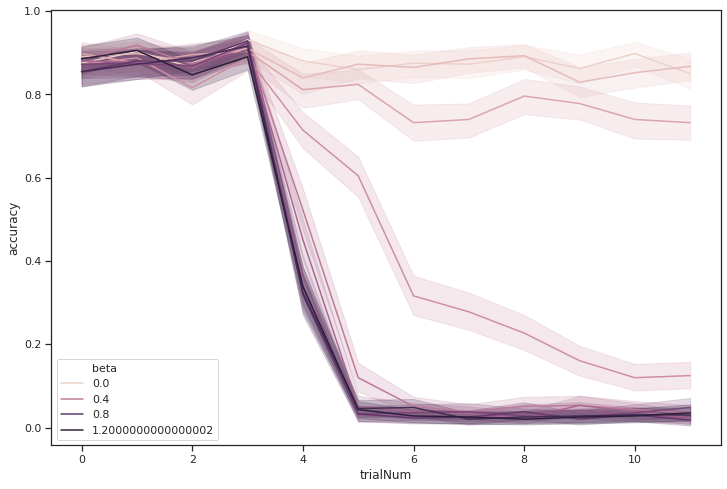

In [27]:
fig = plt.figure(figsize=(12,8))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend':False})
sns.set(style="ticks", rc={"lines.linewidth": 1.5})
sns.lineplot(data=df_model, y='accuracy', x='trialNum', hue='beta')

<Figure size 1440x576 with 0 Axes>

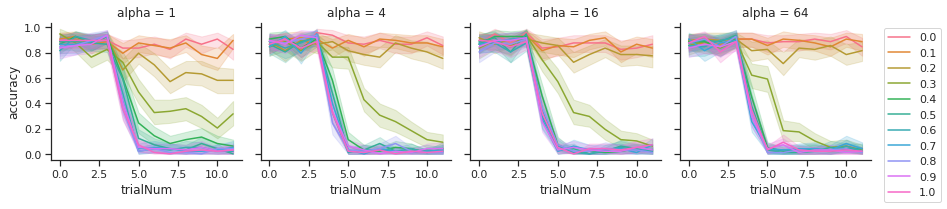

In [28]:
fig = plt.figure(figsize=(20,8))
sns.set_context('poster')
sns.set_style('whitegrid')
sns.set(style="ticks", rc={"lines.linewidth": 1.5})
g = sns.FacetGrid(df_model, col='alpha', col_wrap=8, hue='beta')
g.map(sns.lineplot, 'trialNum', 'accuracy')
plt.legend(bbox_to_anchor=(1.04, 1))


<Figure size 864x720 with 0 Axes>

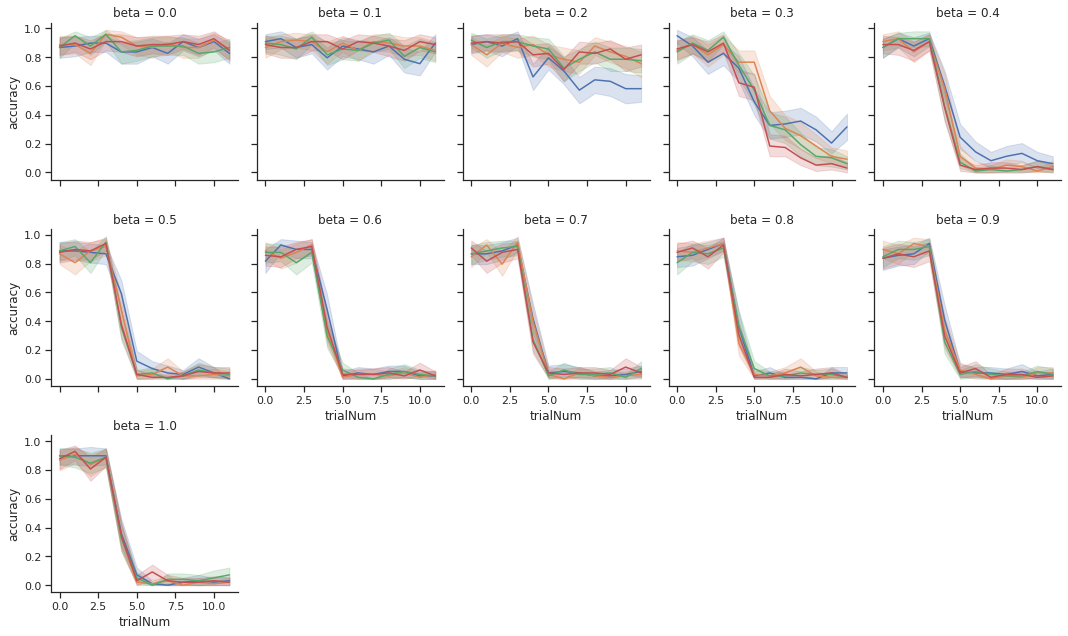

In [29]:
fig = plt.figure(figsize=(12,10))
sns.set_context('poster')
sns.set_style('whitegrid')
sns.set(style="ticks", rc={"lines.linewidth": 1.5})
g = sns.FacetGrid(df_model, col='beta', col_wrap=5, hue='alpha')
g.map(sns.lineplot, 'trialNum', 'accuracy')

## Number of instructions

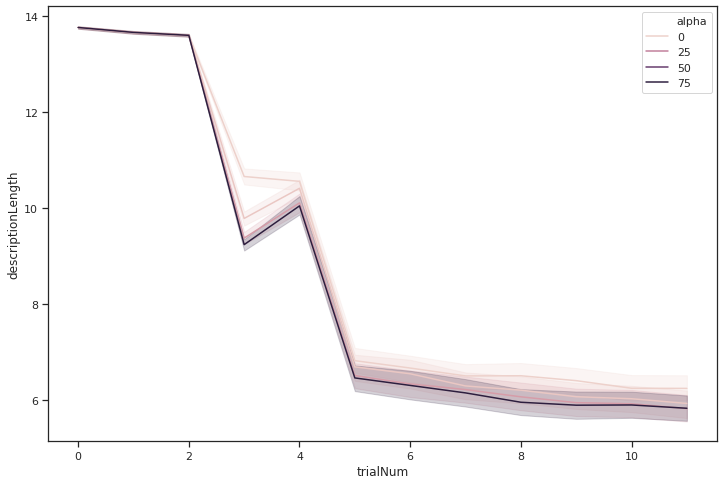

In [30]:
fig = plt.figure(figsize=(12,8))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend':False})
sns.set(style="ticks", rc={"lines.linewidth": 1.5})
sns.lineplot(data=df_model, y='descriptionLength', x='trialNum', hue='alpha')

<Figure size 1440x576 with 0 Axes>

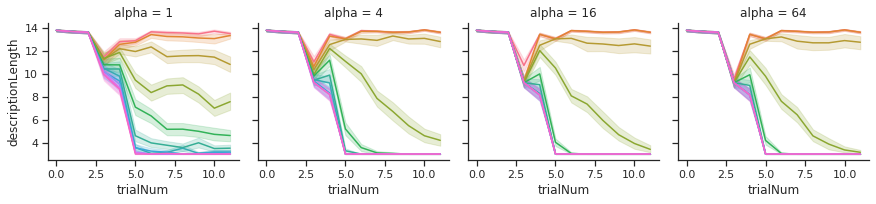

In [31]:
fig = plt.figure(figsize=(20,8))
sns.set_context('poster')
sns.set_style('whitegrid')
sns.set(style="ticks", rc={"lines.linewidth": 1.5})
g = sns.FacetGrid(df_model, col='alpha', col_wrap=8, hue='beta')
g.map(sns.lineplot, 'trialNum', 'descriptionLength')